## Exploring data


In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### movie_gross CSV file

In [26]:
movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### tmdb_movie CSV file

In [90]:
tmdb_movie = pd.read_csv("imdb_with_movie_gross_V2.csv")
tmdb_movie.head()

,genre_ids,id_x,popularity,release_date_x,vote_average,vote_count,id_y,movie,production_budget,domestic_gross,worldwide_gross,profit,roi
0,"[14, 12, 16, 10751]",10191,28.734,2010-03-26,7.7,7610,30,How To Train Your Dragon,165000000.0,217581232.0,494870992.0,329870992,299.921813
1,"[12, 28, 878]",10138,28.515,2010-05-07,6.8,12368,15,Iron Man 2,170000000.0,312433331.0,621156389.0,451156389,365.386111
2,"[16, 35, 10751]",862,28.005,1995-11-22,7.9,10174,37,Toy Story,30000000.0,191796233.0,364545516.0,334545516,1215.151720
3,"[28, 878, 12]",27205,27.920,2010-07-16,8.3,22186,38,Inception,160000000.0,292576195.0,835524642.0,675524642,522.202901
4,"[12, 14, 10751]",32657,26.691,2010-02-11,6.1,4229,17,Percy Jackson & The Olympians: The Lightning T...,95000000.0,88768303.0,223050874.0,128050874,234.790394


In [91]:
tmdb_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2180 entries, 0 to 2179
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          2180 non-null   object 
 1   id_x               2180 non-null   int64  
 2   popularity         2180 non-null   float64
 3   release_date_x     2180 non-null   object 
 4   vote_average       2180 non-null   float64
 5   vote_count         2180 non-null   int64  
 6   id_y               2180 non-null   int64  
 7   movie              2180 non-null   object 
 8   production_budget  2180 non-null   float64
 9   domestic_gross     2180 non-null   float64
 10  worldwide_gross    2180 non-null   float64
 11  profit             2180 non-null   int64  
 12  roi                2180 non-null   float64
dtypes: float64(6), int64(4), object(3)
memory usage: 221.5+ KB


In [92]:
tmdb_movie = tmdb_movie.reset_index()

In [93]:
# Filtering movies that are released between 2010 and 2018
tmdb_movie['release_year'] = tmdb_movie['release_date_x'].str[:4].astype(int)
tmdb_movie = tmdb_movie.loc[(tmdb_movie['release_year'] >= 2010) & (tmdb_movie['release_year'] <= 2018)]
tmdb_movie['release_year'].value_counts()

release_year
2014    273
2011    272
2015    269
2013    257
2010    245
2016    233
2012    226
2017    177
2018    164
Name: count, dtype: int64

From calling the `.info()` method, there seems to be no missing values to deal with. However, the `genre_ids` column is notable because it contains strings that appear to be lists with numerical values.

Since all `genre_ids` are encoded, we match the numeric codes to the actual genre strings, based on information found [here](https://www.themoviedb.org/talk/5f58b094befb0900355684a6), and create another column called `genre` that contains a list of genres.

In [94]:
# A dictionary containing the genre_ids as keys and genres as values
tmdb_genre_list = {
            '28': 'Action',
            '12': 'Adventure',
            '16': 'Animation',
            '35': 'Comedy',
            '80': 'Crime',
            '99': 'Documentary',
            '18': 'Drama',
            '10751': 'Family',
            '14': 'Fantasy',
            '36': 'History',
            '27': 'Horror',
            '10402': 'Music',
            '9648': 'Mystery',
            '10749': 'Romance',
            '878': 'ScienceFiction',
            '10770': 'TVMovie',
            '53': 'Thriller',
            '10752': 'War',
            '37': 'Western'
}

In [95]:
# Changing format of genre_ids to a list
# Note that the numerical values are still in strings

tmdb_movie['genre_ids'] = tmdb_movie['genre_ids'].str.strip('][').str.split(', ')
tmdb_movie['genre_ids'].head()

0    [14, 12, 16, 10751]
1          [12, 28, 878]
3          [28, 878, 12]
4        [12, 14, 10751]
6        [16, 10751, 35]
Name: genre_ids, dtype: object

In [96]:
# Changing the numerical values to actual genres
# Creating a function to match with the genre list created above.
# If the number is not in the list, return 'Unknown'
def clean_genre(genre):
    new_genre = []
    for id in genre:
        if id in tmdb_genre_list.keys():
            new_genre.append(tmdb_genre_list[id])
        else:
            new_genre = 'Unknown'
    return new_genre

# Using this function to change numbers to genres
tmdb_movie['genre'] = tmdb_movie['genre_ids'].map(clean_genre)



One of the notable categories is the **Unknown** category. This category may contain a numeric genre_id that is not specified in the `tmdb_genre_list` dictionary, or have no numeric id. Since there are 2479 entries with the **Unknown** out of about 26500, we decide to drop the movies that have the **Unknown** category.

In [97]:
# Dropping the Unknown movies
tmdb_movie = tmdb_movie.loc[tmdb_movie['genre'] != 'Unknown']
tmdb_movie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2059 entries, 0 to 2179
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              2059 non-null   int64  
 1   genre_ids          2059 non-null   object 
 2   id_x               2059 non-null   int64  
 3   popularity         2059 non-null   float64
 4   release_date_x     2059 non-null   object 
 5   vote_average       2059 non-null   float64
 6   vote_count         2059 non-null   int64  
 7   id_y               2059 non-null   int64  
 8   movie              2059 non-null   object 
 9   production_budget  2059 non-null   float64
 10  domestic_gross     2059 non-null   float64
 11  worldwide_gross    2059 non-null   float64
 12  profit             2059 non-null   int64  
 13  roi                2059 non-null   float64
 14  release_year       2059 non-null   int64  
 15  genre              2059 non-null   object 
dtypes: float64(6), int64(6), obje

In [98]:
# Creating 7 columns to store individaul genres for movies that have more than one genre
split = pd.DataFrame(tmdb_movie['genre'].to_list(), columns = ['main_genre', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7'])
tmdb_movie = pd.concat([tmdb_movie, split], axis=1)
tmdb_movie.head()

,index,genre_ids,id_x,popularity,release_date_x,vote_average,vote_count,id_y,movie,production_budget,...,roi,release_year,genre,main_genre,genre2,genre3,genre4,genre5,genre6,genre7
0,0.0,"[14, 12, 16, 10751]",10191.0,28.734,2010-03-26,7.7,7610.0,30.0,How To Train Your Dragon,165000000.0,...,299.921813,2010.0,"[Fantasy, Adventure, Animation, Family]",Fantasy,Adventure,Animation,Family,None,None,None
1,1.0,"[12, 28, 878]",10138.0,28.515,2010-05-07,6.8,12368.0,15.0,Iron Man 2,170000000.0,...,365.386111,2010.0,"[Adventure, Action, ScienceFiction]",Adventure,Action,ScienceFiction,None,None,None,None
3,3.0,"[28, 878, 12]",27205.0,27.920,2010-07-16,8.3,22186.0,38.0,Inception,160000000.0,...,522.202901,2010.0,"[Action, ScienceFiction, Adventure]",Adventure,Fantasy,Family,None,None,None,None
4,4.0,"[12, 14, 10751]",32657.0,26.691,2010-02-11,6.1,4229.0,17.0,Percy Jackson & The Olympians: The Lightning T...,95000000.0,...,234.790394,2010.0,"[Adventure, Fantasy, Family]",Animation,Family,Comedy,None,None,None,None
6,6.0,"[16, 10751, 35]",10193.0,24.445,2010-06-17,7.7,8340.0,47.0,Toy Story 3,200000000.0,...,534.439761,2010.0,"[Animation, Family, Comedy]",Animation,Action,Comedy,Family,ScienceFiction,None,None


In [99]:
# Filtering to only analyze from movies with more than 10 votes
reviews_more_than_10 = tmdb_movie.loc[tmdb_movie['vote_count'] > 10]
reviews_more_than_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1750 entries, 0 to 2166
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              1750 non-null   float64
 1   genre_ids          1750 non-null   object 
 2   id_x               1750 non-null   float64
 3   popularity         1750 non-null   float64
 4   release_date_x     1750 non-null   object 
 5   vote_average       1750 non-null   float64
 6   vote_count         1750 non-null   float64
 7   id_y               1750 non-null   float64
 8   movie              1750 non-null   object 
 9   production_budget  1750 non-null   float64
 10  domestic_gross     1750 non-null   float64
 11  worldwide_gross    1750 non-null   float64
 12  profit             1750 non-null   float64
 13  roi                1750 non-null   float64
 14  release_year       1750 non-null   float64
 15  genre              1750 non-null   object 
 16  main_genre         1650 non-n

In [100]:
# Checking number of movies per genre
reviews_more_than_10['main_genre'].value_counts()

main_genre
Drama             424
Comedy            272
Action            240
Horror            128
Thriller          117
Adventure          80
Documentary        72
Crime              64
Animation          54
Romance            43
ScienceFiction     38
Fantasy            29
Family             25
Mystery            21
History            13
War                12
Music              10
Western             5
TVMovie             3
Name: count, dtype: int64

Text(0, 0.5, 'Number of Movies')

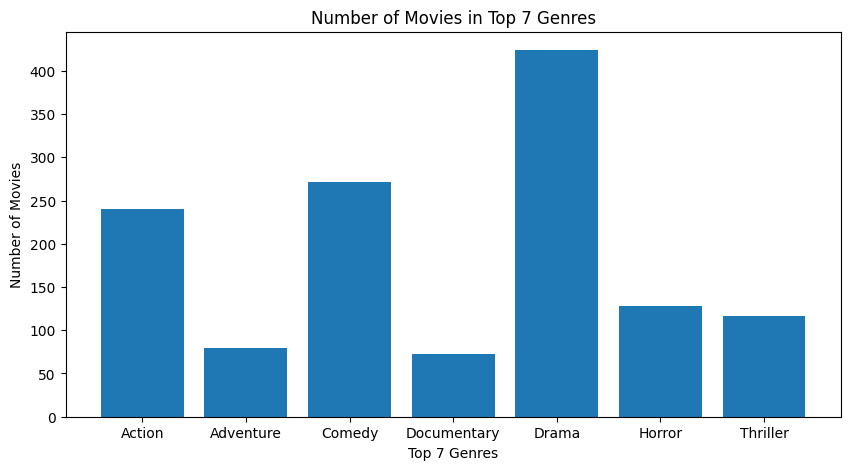

In [101]:
# Visualizing the number of movies in top 7 movie genres
# First, creating a dictionary with genres and counts
top_7_genres_index = list(reviews_more_than_10['main_genre'].value_counts()[:7].keys())
top_7_genre_counts = reviews_more_than_10['main_genre'].value_counts()[:7]
top_7_genres = dict(zip(top_7_genres_index, top_7_genre_counts))

# Then, sorting them alphabetically for the visualization
top_7_genres_index.sort()
top_7_genres_sorted = {i: top_7_genres[i] for i in top_7_genres_index}

# Visualizing in a bar graph
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(top_7_genres_sorted.keys(), top_7_genres_sorted.values())
ax.set_title("Number of Movies in Top 7 Genres")
ax.set_xlabel("Top 7 Genres")
ax.set_ylabel("Number of Movies")

In [102]:
# Grouping by genre for top 7 genre, and getting the vote average
genre_tmdb = reviews_more_than_10.loc[reviews_more_than_10['main_genre'].isin(top_7_genres)].groupby('main_genre')
genre_tmdb['vote_average'].mean()
genre_tmdb['popularity'].mean()

main_genre
Action         11.035996
Adventure      11.468238
Comedy         11.585066
Documentary     9.755847
Drama          11.657866
Horror         12.375922
Thriller       12.739650
Name: popularity, dtype: float64

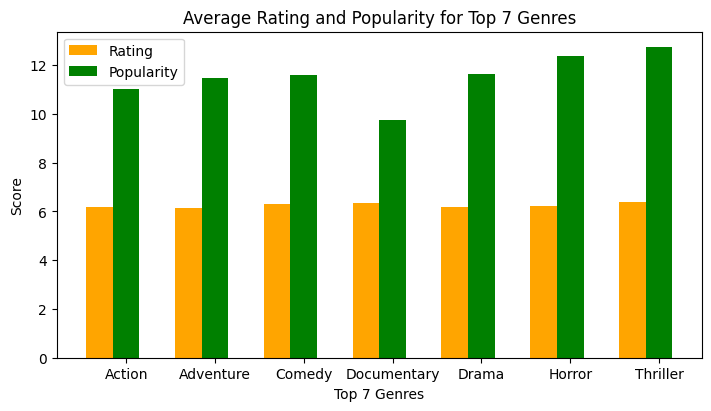

In [103]:
# Visualizing the top 7 genres and their average ratings
fig, ax = plt.subplots(figsize=(7,4), layout='constrained')

x = np.arange(len(top_7_genres_sorted))
y_rating = genre_tmdb['vote_average'].mean()
ax.bar(x - 0.3, y_rating, 0.3, color='orange', label='Rating')

y_popularity = genre_tmdb['popularity'].mean()
ax.bar(top_7_genres_sorted.keys(), y_popularity, 0.3, color='green', label='Popularity')


ax.set_title("Average Rating and Popularity for Top 7 Genres")
ax.set_xlabel("Top 7 Genres")
ax.set_ylabel("Score")
ax.legend()

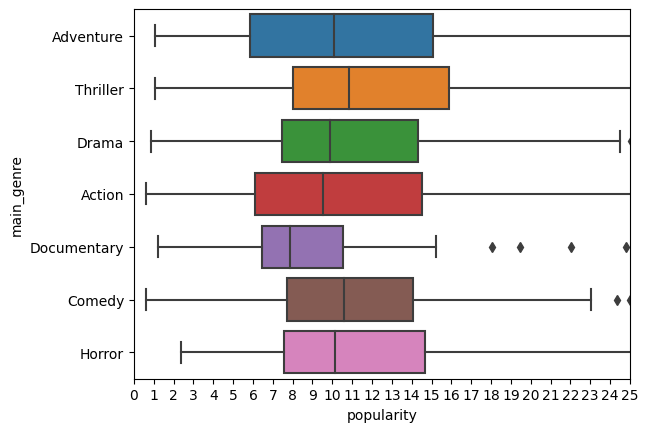

In [104]:
# Boxplot for popularity
top_7_genres_df = reviews_more_than_10.loc[reviews_more_than_10['main_genre'].isin(top_7_genres_index)]
top_7_genres_df['main_genre'].value_counts()

fig, ax = plt.subplots()
sns.boxplot(x=top_7_genres_df['popularity'], y=top_7_genres_df['main_genre'])
ax.set_xlim(0,25)
ax.set_xticks(range(0,26))
plt.show()

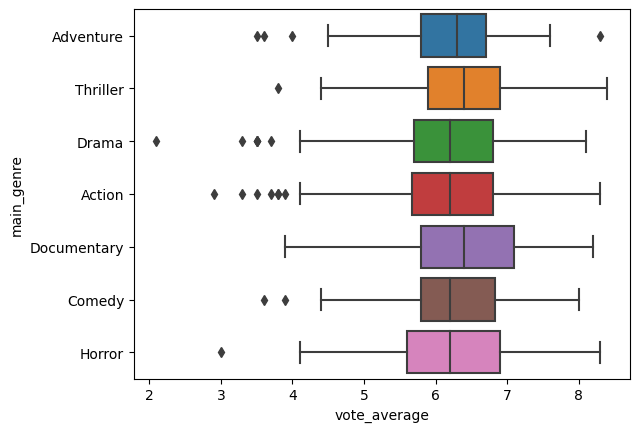

In [105]:
# Boxplot for vote average
fig, ax = plt.subplots()
sns.boxplot(x=top_7_genres_df['vote_average'], y=top_7_genres_df['main_genre'])
plt.show()

### Linear Regression

In [106]:
# Removing null values before running linear regression
tmdb_movie['production_budget'].isna().sum()

tmdb_movie.dropna(subset='production_budget', inplace=True)
tmdb_movie['profit'].isna().sum()

0

In [107]:
# Changing values so that they are in millions for visualization
columns = ['production_budget', 'profit']

tmdb_movie[columns] = tmdb_movie[columns].apply(lambda x: x/1000000)
tmdb_movie[columns]

,production_budget,profit
0,165.0,329.870992
1,170.0,451.156389
3,160.0,675.524642
4,95.0,128.050874
6,200.0,868.879522
...,...,...
2173,25.0,9.356760
2174,25.0,9.356760
2176,25.0,9.356760
2177,38.0,12.970660


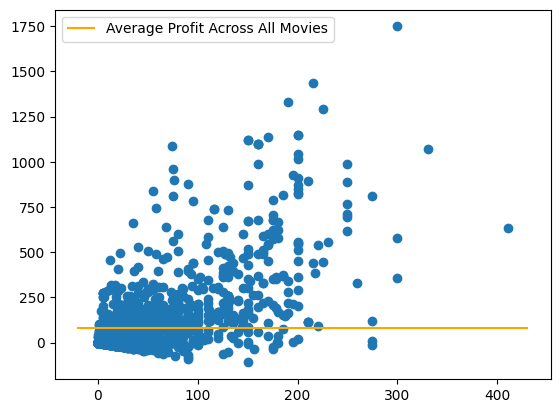

In [108]:
# Baseline model is the overall average profit across all movies 
X = tmdb_movie['production_budget'].values
y = tmdb_movie['profit'].values

plt.scatter(X, y)

xmin, xmax = plt.xlim()
plt.hlines(y=y.mean(),
            xmin=xmin, xmax=xmax,
            label="Average Profit Across All Movies",
            colors='orange')

plt.legend()

#### Linear Regression Model Between Production Budget and Profit

In [109]:
from sklearn.linear_model import LinearRegression

In [110]:
lr = LinearRegression()

In [111]:
lr.fit(tmdb_movie[['production_budget']], y)

LinearRegression()

In [112]:
# Getting our linear regression model
m = lr.coef_
b = lr.intercept_
lm_model = m*tmdb_movie['production_budget'].values + b

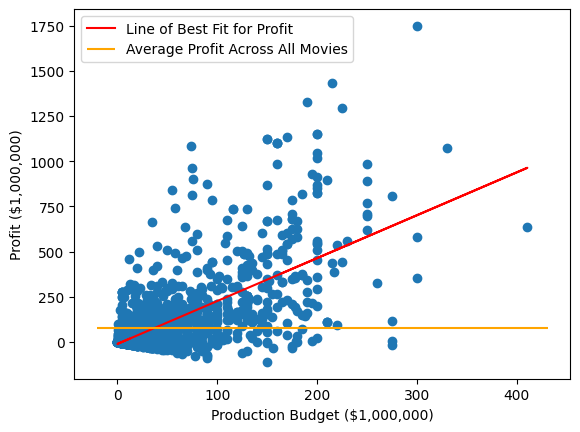

In [113]:
# Creating a scatter plot with the baseline model and the linear regression model
plt.scatter(X, y)
plt.plot(tmdb_movie['production_budget'].values, 
        lm_model, 
        label = 'Line of Best Fit for Profit',
        color='red')

xmin, xmax = plt.xlim()
plt.hlines(y=y.mean(),
            xmin=xmin, xmax=xmax,
            label="Average Profit Across All Movies",
            colors='orange')

plt.xlabel('Production Budget ($1,000,000)')
plt.ylabel('Profit ($1,000,000)')
plt.legend()
# same as this
# sns.lmplot(x='production_budget', y='worldwide_gross', data=tn_movie_budgets)

In [114]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [115]:
# Calculating metrics to evaluate the model
r2_score(y, lm_model)

0.4631982713370796

In [116]:
mean_squared_error(y, lm_model)

17165.476604872674

In [117]:
# Comparing with our baseline model
base_model = 0*tmdb_movie['production_budget'].values + y.mean()
r2_score(y, base_model)

0.0

In [118]:
mean_squared_error(y, base_model)

31977.31245692686

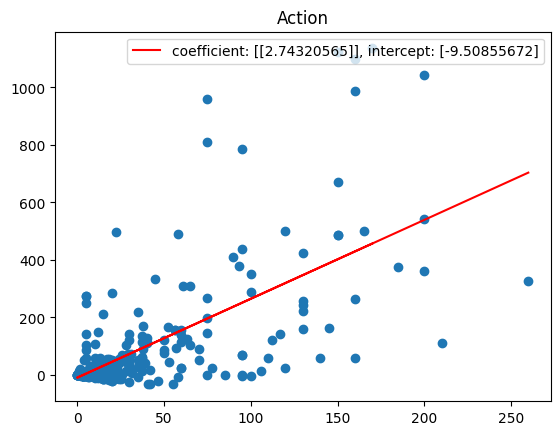

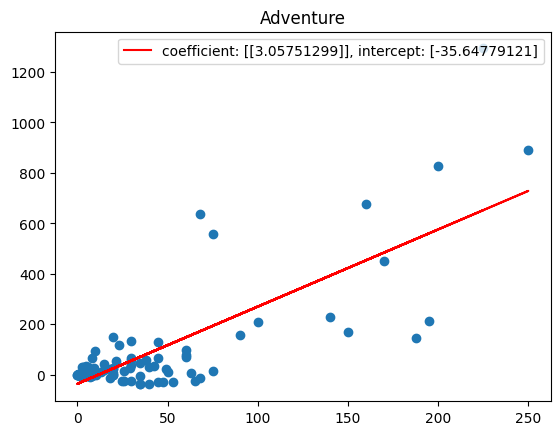

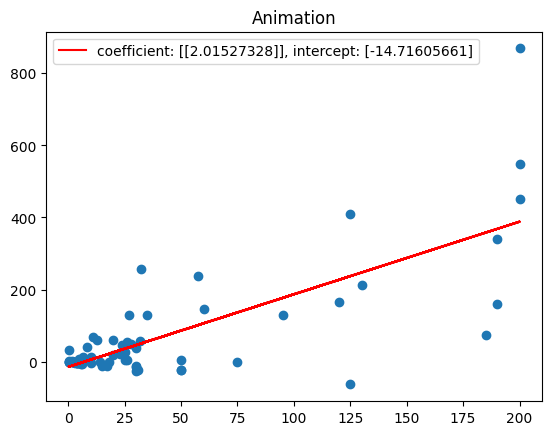

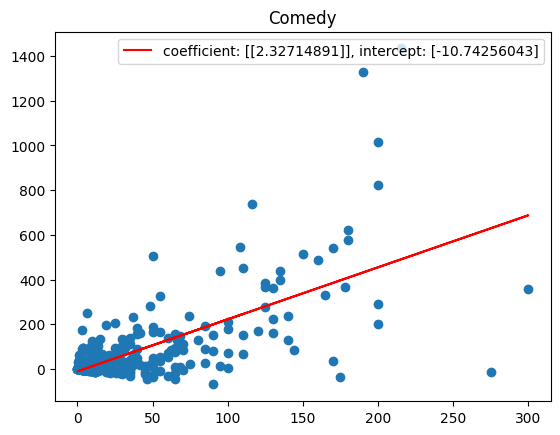

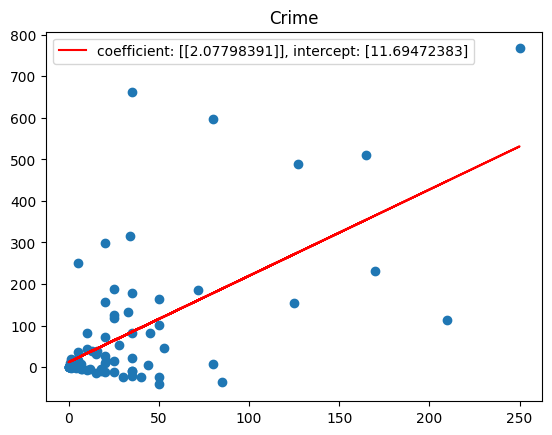

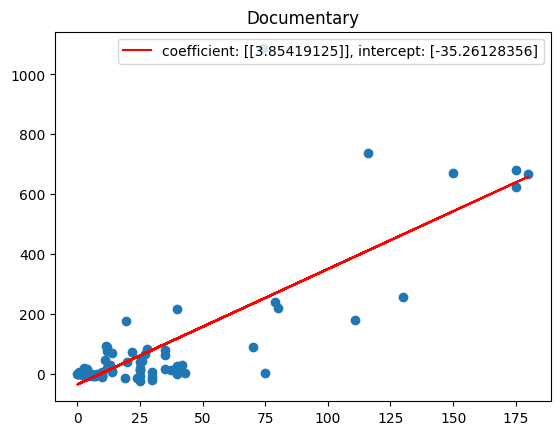

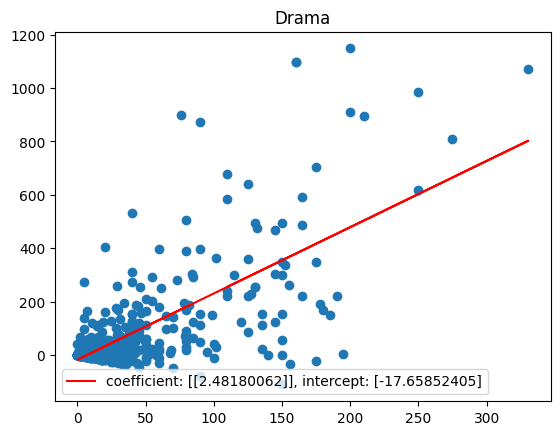

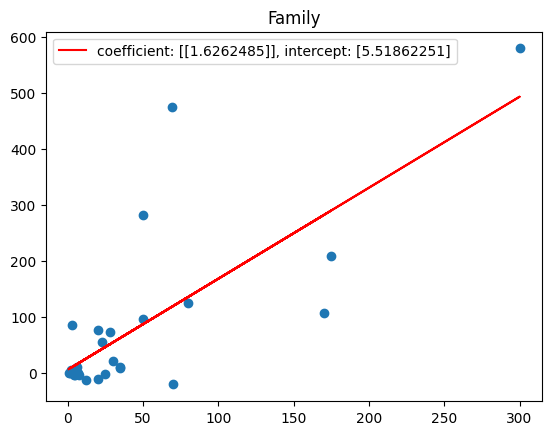

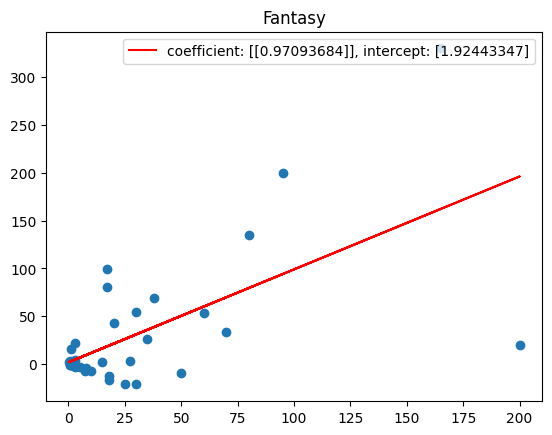

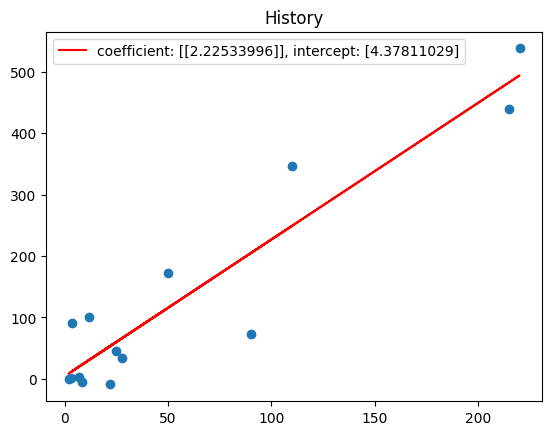

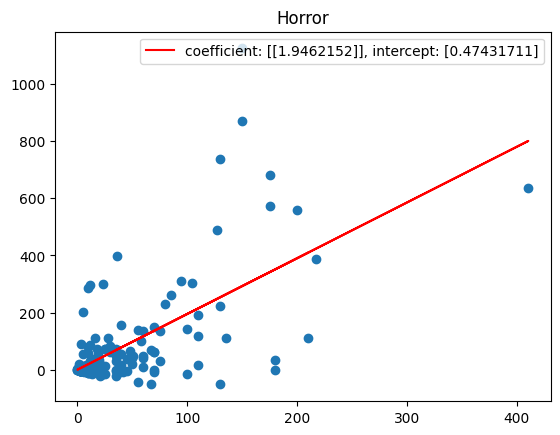

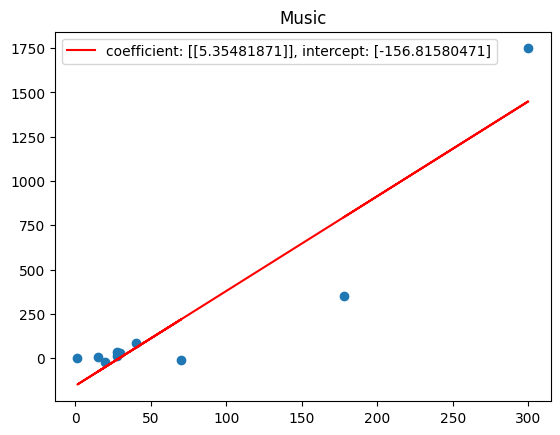

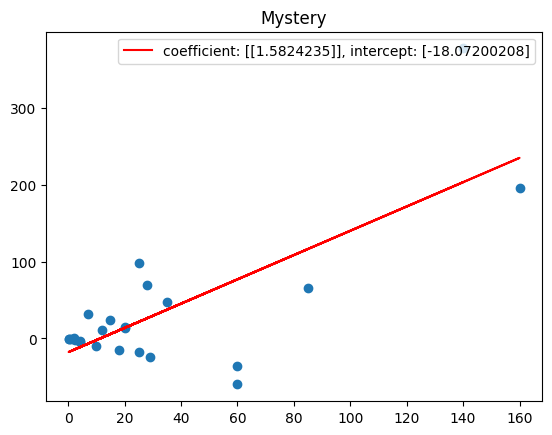

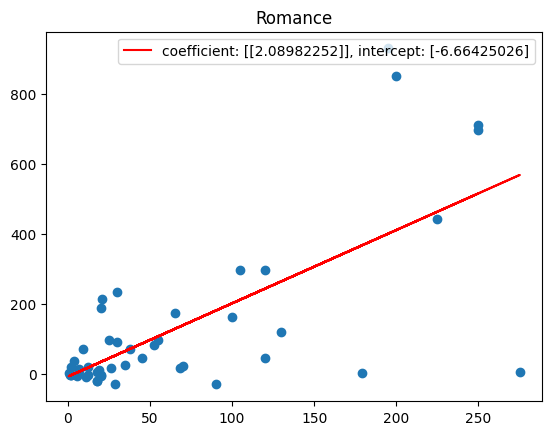

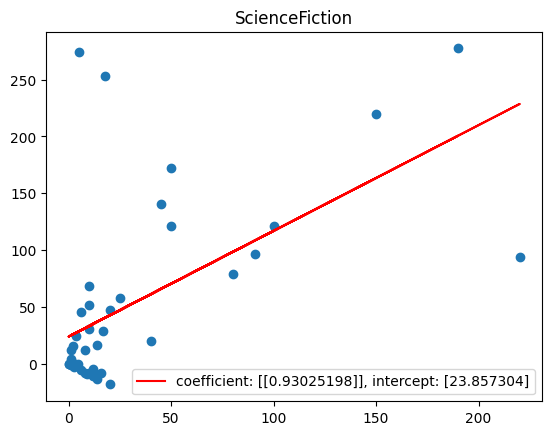

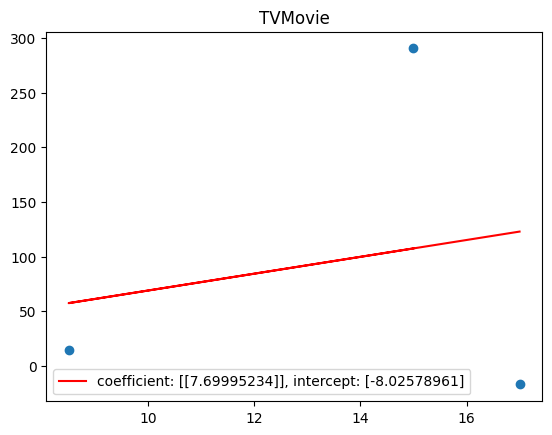

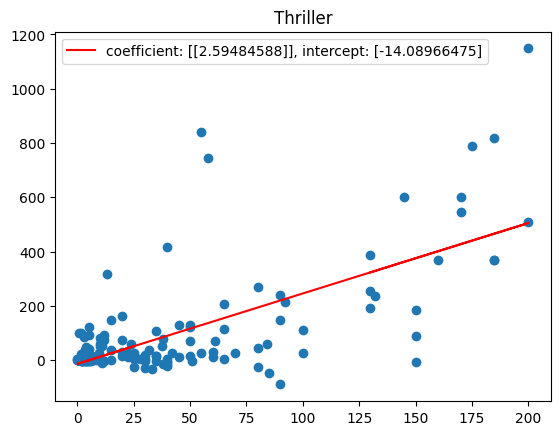

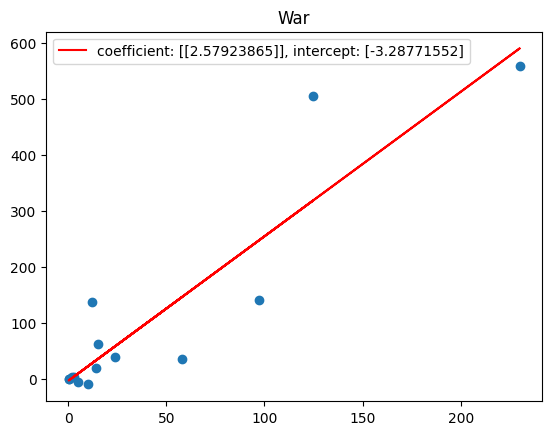

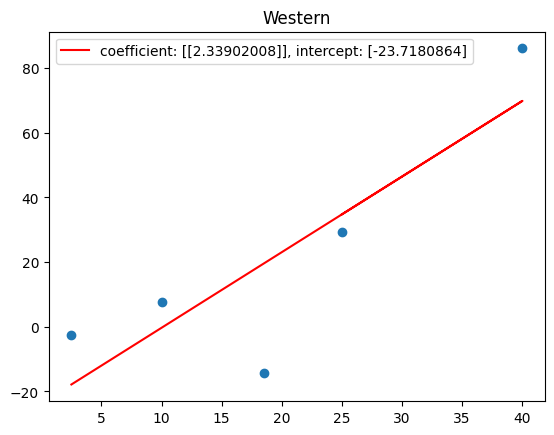

""


In [125]:
# Trying group wise linear regression and plot them individually
grouped_tmdb_movie = tmdb_movie.groupby(['main_genre'])

def model(df):
    y = df[['profit']].values
    X = df[['production_budget']].values
    lr = LinearRegression()
    lr.fit(X, y)
    m = lr.coef_
    b = lr.intercept_
    y_model = m*X + b
    plt.scatter(X,y)
    plt.plot(X, y_model, color='red', label=f"coefficient: {m}, intercept: {b}")
    plt.title(f"{df['main_genre'].values[0]}")
    plt.legend()
    plt.show()

grouped_tmdb_movie.apply(model)

In [28]:
reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", sep='\t', encoding='latin1')
reviews['id'].value_counts()

id
782     338
1067    275
1525    262
1777    260
1083    260
       ... 
1393      1
411       1
770       1
1125      1
1526      1
Name: count, Length: 1135, dtype: int64

In [35]:
grouped_reviews = reviews.groupby('id')
grouped_reviews.count()['review'].describe()

count    1135.000000
mean       43.056388
std        56.670793
min         0.000000
25%         4.000000
50%        15.000000
75%        67.000000
max       338.000000
Name: review, dtype: float64

## SQLite IMDB

In order to unzip the database file, run the following prompt in terminal

`tar -xf "zippedData/im.db.zip"`

In [4]:
conn = sqlite3.connect("im.db")


In [4]:
pd.read_sql("""
SELECT *
FROM persons
""", conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer
